In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
pwd

'c:\\Users\\ysnow\\OneDrive\\Desktop\\Blockhouse'

## Data Preparation

In [4]:
data = pd.read_excel('UST_Data(07-09-2024).xlsx')

In [5]:
data.head()

,let me tak,Id,Client,RFQStatus,InstrumentSubGroup,Market Traded Vol (USD),Our Traded Vol,TiedWonVol,Num of Dealers,Trader,...,SettlementDays,SettlementDate,SettlementStops,RFQ CreateTime,RFQ ClosedTime,AnAutoReplyRFQs,First Response Time (Sec),TradeSizeBucket,Sector,MaturityBucket
0,2024-09-30,66FA7D45432800D20002,Client1,Done,OFFTHERUN,100000000,100000000,100000000,6,Trader1,...,1,2024-10-01,T+1,2024-09-30 06:28:00,2024-09-30 06:28:00,1,0.03,50+M,5-7 YR,5y-7y
1,2024-09-30,TRSY_20240930_15961,Client2,Done,"OFFTHERUN,DOUBLEOLDS",2100000,2100000,2100000,5,Trader2,...,1,2024-10-01,T+1,2024-09-30 16:00:00,2024-09-30 16:00:00,1,0.95,1-5M,7-10 YR,7y-10y
2,2024-09-30,TRSY_20240930_314,Client2,Done,ONTHERUN,53000000,53000000,53000000,5,Trader3,...,1,2024-10-01,T+1,2024-09-30 15:46:00,2024-09-30 15:46:00,1,0.07,50+M,7-10 YR,7y-10y
3,2024-09-30,66FAEA57432800020001,Client3,Done,OFFTHERUN,500000,500000,500000,5,Trader4,...,1,2024-10-01,T+1,2024-09-30 14:14:00,2024-09-30 14:14:00,1,0.03,500K-1M,0-1 YR,<18mos
4,2024-09-30,66FAC35D455C00210006,Client4,Done,OFFTHERUN,1058000,1058000,1058000,5,Trader2,...,1,2024-10-01,T+1,2024-09-30 11:27:00,2024-09-30 11:27:00,1,0.03,1-5M,5-7 YR,3y-5y


In [6]:
# make a copy of raw data
df = data

In [7]:
missing_values = df.isnull().sum()
null = missing_values[missing_values > 0]
null

TickIdentifier    445
dtype: int64

In [8]:
# drop null value
df.dropna(inplace=True)

In [9]:
# Count of "TFRNS"
tfrns_count = data[data['AssetClass'] == 'TFRNS'].shape[0]

print(f'Total number of TFRNS in AssetClass column: {tfrns_count}')

Total number of TFRNS in AssetClass column: 64


In [10]:
df = df[df['AssetClass'] != 'TFRNS']

In [11]:
def years_to_maturity(row):
    maturity_date = pd.to_datetime(row['Maturity Date'])
    trade_date = pd.to_datetime(row['let me tak'])
    ytm = (maturity_date - trade_date).days / 365.25
    return ytm

def extract_yield(description):
    match = re.search(r"(\d+\.\d+)", description)
    return float(match.group(1)) if match else np.nan

def bond(ytm, years, face_value=100):
    if pd.isna(ytm) or pd.isna(years):
        return np.nan
    bond_price = face_value / ((1 + 0.01 * ytm) ** years)
    return bond_price

def tbill(face_value, deal_price, days_to_maturity):
    if pd.isna(deal_price) or pd.isna(days_to_maturity):
        return np.nan
    discount_yield = ((face_value - deal_price) / face_value) * (360 / days_to_maturity)
    tbill_price = face_value * (1 - (discount_yield / 100) * (days_to_maturity / 360))
    return tbill_price

In [12]:
df['Years to Maturity'] = df.apply(years_to_maturity, axis=1)
df['Yield'] = df['InstrumentDescription'].apply(extract_yield)

In [13]:
# Columns to convert
columns_to_convert = ['Best Bid Price', 'Mid Price', 'Best Ask Price', 'Deal Value', 'Cover']

for column in columns_to_convert:
    df[f'Converted {column}'] = df.apply(
        lambda row: (
            # yield_to_price(row['Yield'], row['Years to Maturity']) if row['AssetClass'] == 'STRIPS'
            # else (
                tbill(100, row[column], (pd.to_datetime(row['Maturity Date']) - pd.to_datetime(row['let me tak'])).days)
                if (row['AssetClass'] == 'BILLS' or row['AssetClass'] == 'STRIPS')else row[column]
            # )
        ),
        axis=1
    )

df[['InstrumentDescription', 'AssetClass', 'Yield', 'Years to Maturity'] + [f'Converted {col}' for col in columns_to_convert]]

,InstrumentDescription,AssetClass,Yield,Years to Maturity,Converted Best Bid Price,Converted Mid Price,Converted Best Ask Price,Converted Deal Value,Converted Cover
0,T 3.500 04/30/30,BONDS,3.500,-94.420260,99.539062,99.550781,99.562500,99.558594,99.558594
1,T 4.000 02/15/34,BONDS,4.000,-90.622861,101.712388,101.724107,101.735826,101.726562,101.726562
2,T 3.625 09/30/31 7YR,BONDS,3.625,-93.002053,99.761719,99.765625,99.769531,99.761719,99.761719
3,T 3.500 09/15/25,BONDS,3.500,0.958248,99.535156,99.539062,99.542969,99.554688,99.554688
4,T 4.000 06/30/28,BONDS,4.000,3.748118,101.601562,101.609375,101.617188,101.605469,101.605469
...,...,...,...,...,...,...,...,...,...
66676,B 09/26/24 3MO,BILLS,NaN,0.238193,99.052250,99.052225,99.052200,99.052175,99.000000
66677,B 09/26/24 3MO,BILLS,NaN,0.238193,99.052250,99.052225,99.052200,99.052175,99.000000
66678,B 09/26/24 3MO,BILLS,NaN,0.238193,99.052250,99.052225,99.052200,99.052175,99.000000
66679,T 1.000 12/15/24,BONDS,1.000,0.457221,98.085938,98.095703,98.105469,98.132812,0.000000


In [14]:
# Filter for AssetClass that is either BILLS or STRIPS
bill_strip_df = df[df['AssetClass'].isin(['BILLS', 'STRIPS', 'BONDS'])]

# Select only the columns that are related to converted prices
columns_to_display = ['InstrumentDescription', 'AssetClass', 'Yield', 'Years to Maturity'] + [f'Converted {col}' for col in columns_to_convert]

In [15]:
bill_strip_df[columns_to_display].head(10)

,InstrumentDescription,AssetClass,Yield,Years to Maturity,Converted Best Bid Price,Converted Mid Price,Converted Best Ask Price,Converted Deal Value,Converted Cover
0,T 3.500 04/30/30,BONDS,3.500,-94.420260,99.539062,99.550781,99.562500,99.558594,99.558594
1,T 4.000 02/15/34,BONDS,4.000,-90.622861,101.712388,101.724107,101.735826,101.726562,101.726562
2,T 3.625 09/30/31 7YR,BONDS,3.625,-93.002053,99.761719,99.765625,99.769531,99.761719,99.761719
3,T 3.500 09/15/25,BONDS,3.500,0.958248,99.535156,99.539062,99.542969,99.554688,99.554688
4,T 4.000 06/30/28,BONDS,4.000,3.748118,101.601562,101.609375,101.617188,101.605469,101.605469
5,B 10/29/24 1MO,BILLS,NaN,0.079398,99.047425,99.047400,99.047375,99.047345,99.047310
6,T 3.500 09/30/29 5YR,BONDS,3.500,4.999316,99.640625,99.644531,99.648438,99.640625,0.000000
7,T 3.625 09/30/31 7YR,BONDS,3.625,-93.002053,99.726562,99.730469,99.734375,99.734375,0.000000
8,T 3.375 09/15/27 3YR,BONDS,3.375,2.956879,99.546875,99.548828,99.550781,99.546875,0.000000
9,T 3.875 08/15/34 10YR,BONDS,3.875,-90.127310,100.738281,100.742188,100.746094,100.738281,100.738281


In [16]:
df['Spread'] = df['Converted Best Ask Price'] - df['Converted Best Bid Price']

In [17]:
def slippage(row):
    if row['Buy/Sell'] == 'Buy':
        return (row['Converted Deal Value'] - row['Converted Mid Price'])
    elif row['Buy/Sell'] == 'Sell':
        return (row['Converted Mid Price'] - row['Converted Deal Value'])
    return None

df['Slippage'] = df.apply(slippage, axis=1)

## Visualizations

### old

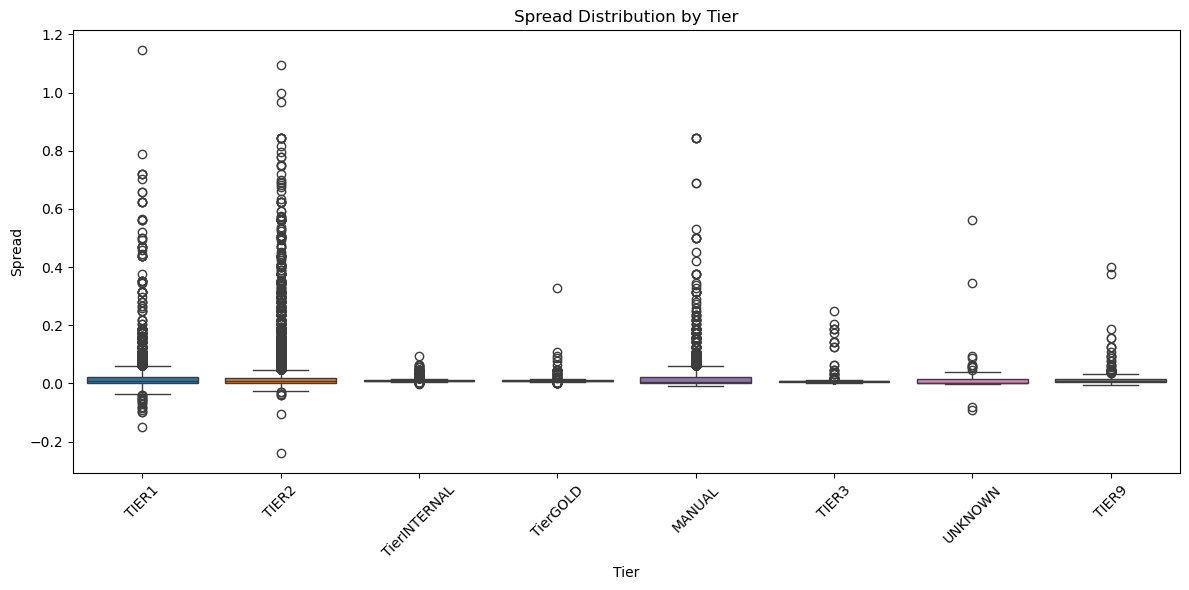

In [35]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Tier', y='Spread', palette='tab10')
plt.title('Spread Distribution by Tier')
plt.xlabel('Tier')
plt.ylabel('Spread')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
df.columns

Index(['let me tak', 'Id', 'Client', 'RFQStatus', 'InstrumentSubGroup',
       'Market Traded Vol (USD)', 'Our Traded Vol', 'TiedWonVol',
       'Num of Dealers', 'Trader', 'Sales', 'Covered Vol', 'ActionStr', 'Tier',
       'InstrumentCode', 'InstrumentDescription', 'AssetClass', 'Market',
       'LegNo', 'Maturity Date', 'RFQNumberOfQuotes', 'Buy/Sell',
       'Best Bid Price', 'Mid Price', 'Best Ask Price', 'Deal Value',
       'AwayFromMid', 'TickIdentifier', 'Deal Spread', 'Cover', 'CoverPnL',
       'SettlementDays', 'SettlementDate', 'SettlementStops', 'RFQ CreateTime',
       'RFQ ClosedTime', 'AnAutoReplyRFQs', 'First Response Time (Sec)',
       'TradeSizeBucket', 'Sector', 'MaturityBucket', 'Years to Maturity',
       'Yield', 'Converted Best Bid Price', 'Converted Mid Price',
       'Converted Best Ask Price', 'Converted Deal Value', 'Converted Cover',
       'Spread', 'Slippage'],
      dtype='object')

In [38]:
df.head(10)

,let me tak,Id,Client,RFQStatus,InstrumentSubGroup,Market Traded Vol (USD),Our Traded Vol,TiedWonVol,Num of Dealers,Trader,...,MaturityBucket,Years to Maturity,Yield,Converted Best Bid Price,Converted Mid Price,Converted Best Ask Price,Converted Deal Value,Converted Cover,Spread,Slippage
0,2024-09-30,66FA7D45432800D20002,Client1,Done,OFFTHERUN,100000000,100000000,100000000,6,Trader1,...,5y-7y,-94.420260,3.500,99.539062,99.550781,99.562500,99.558594,99.558594,0.023438,-0.007812
1,2024-09-30,TRSY_20240930_15961,Client2,Done,"OFFTHERUN,DOUBLEOLDS",2100000,2100000,2100000,5,Trader2,...,7y-10y,-90.622861,4.000,101.712388,101.724107,101.735826,101.726562,101.726562,0.023438,-0.002456
2,2024-09-30,TRSY_20240930_314,Client2,Done,ONTHERUN,53000000,53000000,53000000,5,Trader3,...,7y-10y,-93.002053,3.625,99.761719,99.765625,99.769531,99.761719,99.761719,0.007812,0.003906
3,2024-09-30,66FAEA57432800020001,Client3,Done,OFFTHERUN,500000,500000,500000,5,Trader4,...,<18mos,0.958248,3.500,99.535156,99.539062,99.542969,99.554688,99.554688,0.007812,-0.015625
4,2024-09-30,66FAC35D455C00210006,Client4,Done,OFFTHERUN,1058000,1058000,1058000,5,Trader2,...,3y-5y,3.748118,4.000,101.601562,101.609375,101.617188,101.605469,101.605469,0.015625,-0.003906
5,2024-09-30,66FB01C6432800130001,Client4,Done,ONTHERUN,25000000,25000000,0,5,Trader4,...,<18mos,0.079398,NaN,99.047425,99.047400,99.047375,99.047345,99.047310,-0.000050,0.000055
6,2024-09-30,66FAFF05432800000001,Client5,Done,ONTHERUN,1132000,1132000,0,1,Trader2,...,5y-7y,4.999316,3.500,99.640625,99.644531,99.648438,99.640625,0.000000,0.007812,-0.003906
7,2024-09-30,66FAEFC145C4000A0001,Client5,Done,ONTHERUN,818000,818000,0,1,Trader2,...,7y-10y,-93.002053,3.625,99.726562,99.730469,99.734375,99.734375,0.000000,0.007812,-0.003906
8,2024-09-30,66FA9F0D45C400400001,Client5,Done,ONTHERUN,500000,500000,0,1,Trader2,...,3y-5y,2.956879,3.375,99.546875,99.548828,99.550781,99.546875,0.000000,0.003906,0.001953
9,2024-09-30,66FB0D0C45C400000001,Client5,Done,ONTHERUN,500000,500000,500000,5,Trader2,...,7y-10y,-90.127310,3.875,100.738281,100.742188,100.746094,100.738281,100.738281,0.007812,-0.003906


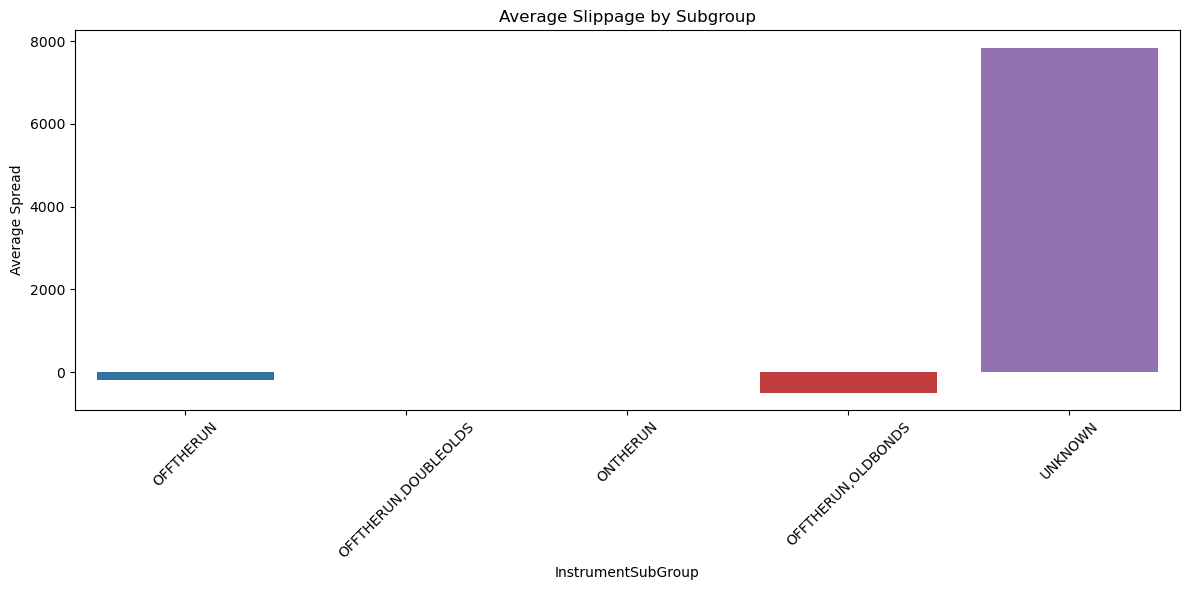

In [65]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='InstrumentSubGroup', y='Slippage', palette='tab10', ci=None)
plt.title('Average Slippage by Subgroup')
plt.xlabel('InstrumentSubGroup')
plt.ylabel('Average Spread')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

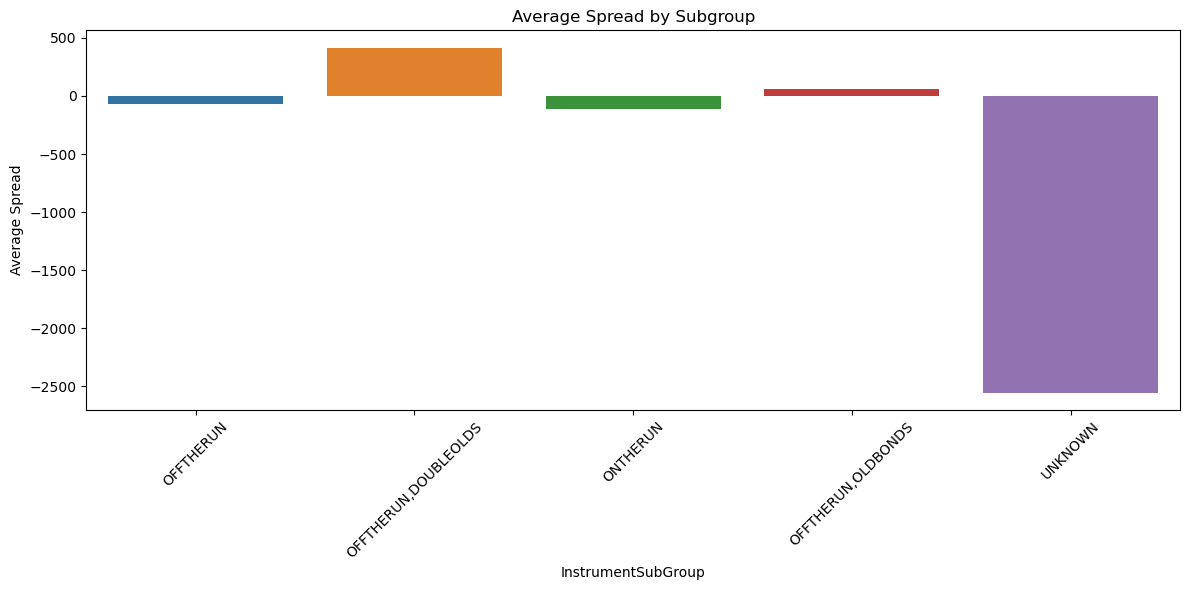

In [47]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='InstrumentSubGroup', y='Deal Value', palette='tab10', ci=None)
plt.title('Average Spread by Subgroup')
plt.xlabel('InstrumentSubGroup')
plt.ylabel('Average Spread')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
df['MaturityBucket'].value_counts()

MaturityBucket
<18mos    31951
10-30y    11585
7y-10y     8338
3y-5y      7051
5y-7y      2849
18m-2y     2243
2y-3y      2155
Name: count, dtype: int64

Text(0.5, 1.0, 'Response Time Distribution by Client Tier')

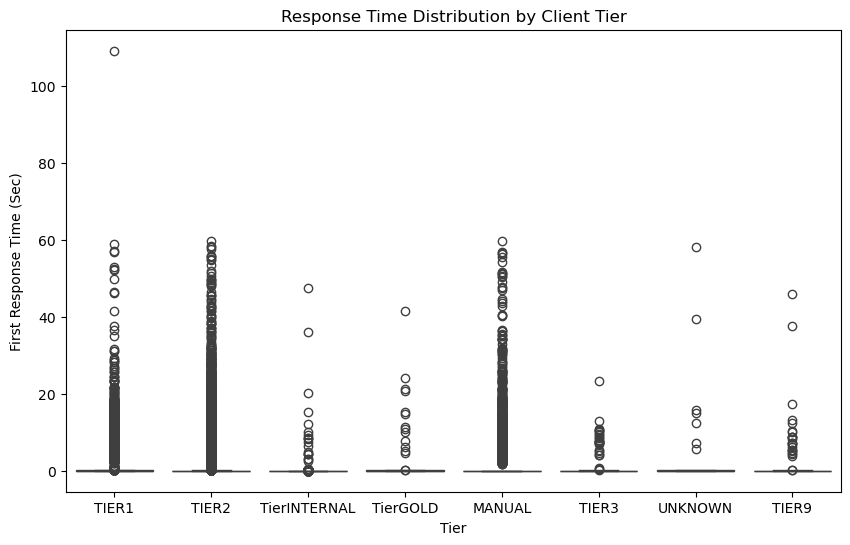

In [56]:
# Response Time Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Tier', y='First Response Time (Sec)')
plt.title('Response Time Distribution by Client Tier')

Text(0.5, 1.0, 'Yield Curve')

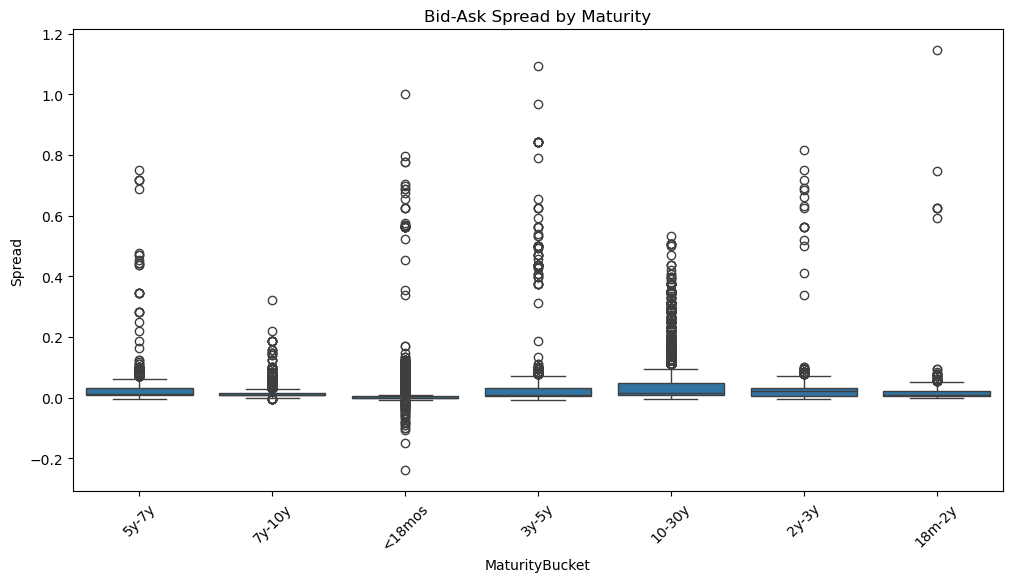

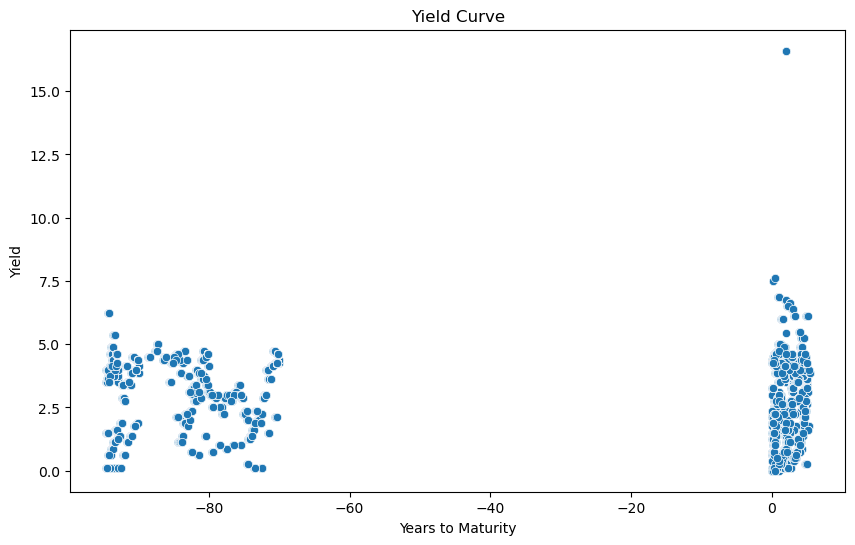

In [57]:
# Bid-Ask Spread by Maturity Bucket
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='MaturityBucket', y='Spread')
plt.title('Bid-Ask Spread by Maturity')
plt.xticks(rotation=45)

# Yield Curve
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Years to Maturity', y='Yield')
plt.title('Yield Curve')

([0, 1, 2, 3, 4],
 [Text(0, 0, 'BONDS'),
  Text(1, 0, 'BILLS'),
  Text(2, 0, 'TIPS'),
  Text(3, 0, 'STRIPS'),
  Text(4, 0, 'UNKNOWN')])

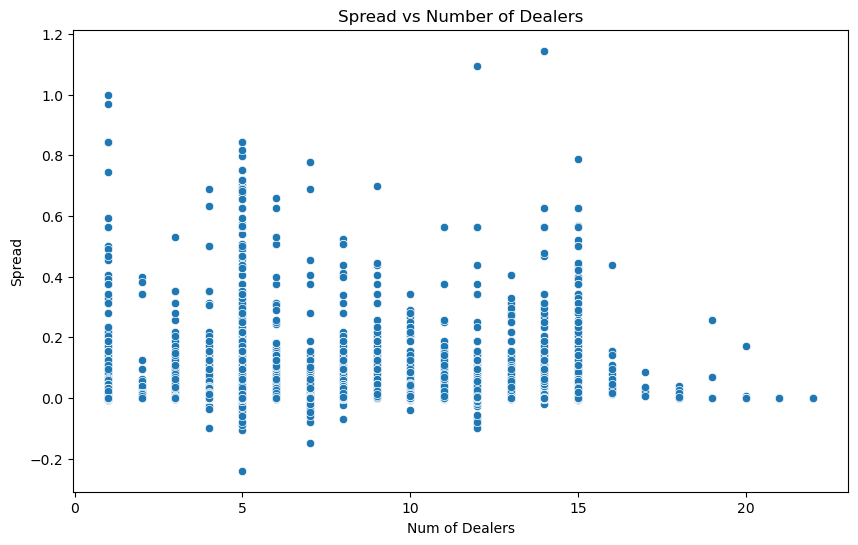

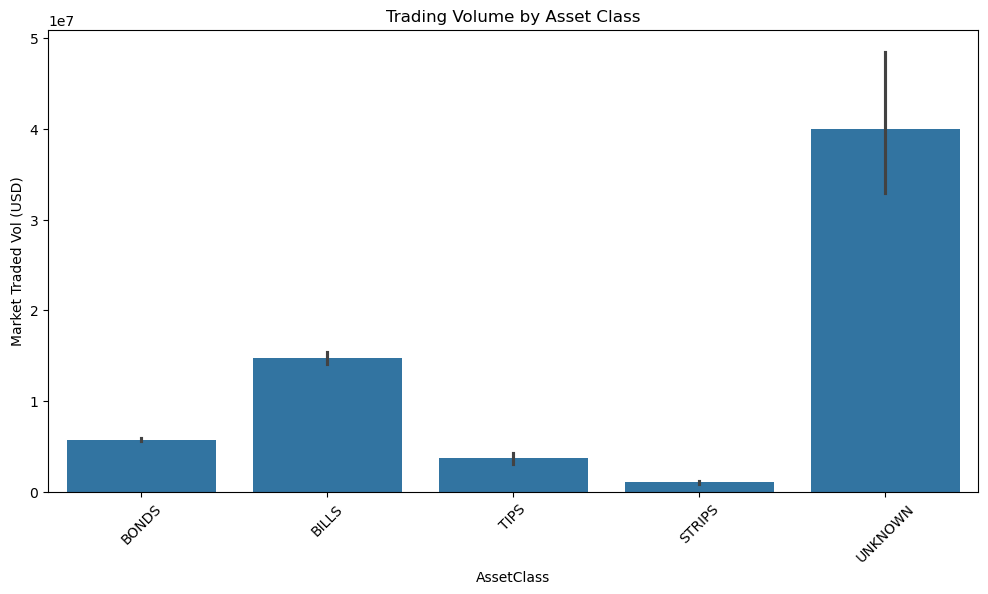

In [58]:
# Number of Dealers vs Spread
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Num of Dealers', y='Spread')
plt.title('Spread vs Number of Dealers')

# Volume by Asset Class
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='AssetClass', y='Market Traded Vol (USD)')
plt.title('Trading Volume by Asset Class')
plt.xticks(rotation=45)

In [61]:
unknown

0                   OFFTHERUN
1        OFFTHERUN,DOUBLEOLDS
2                    ONTHERUN
3                   OFFTHERUN
4                   OFFTHERUN
                 ...         
66676                ONTHERUN
66677                ONTHERUN
66678                ONTHERUN
66679               OFFTHERUN
66680               OFFTHERUN
Name: InstrumentSubGroup, Length: 66172, dtype: object

Text(0, 0.5, 'Volume')

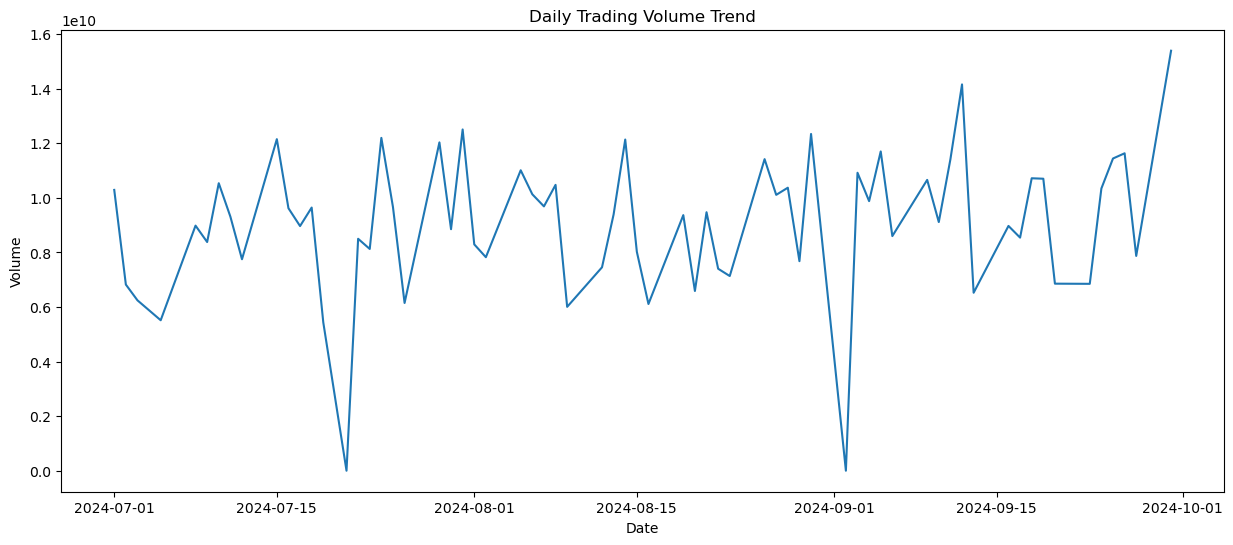

In [62]:
# Daily Trading Volume Trend
df['Date'] = pd.to_datetime(df['let me tak']).dt.date
daily_volume = df.groupby('Date')['Market Traded Vol (USD)'].sum()

plt.figure(figsize=(15, 6))
daily_volume.plot(kind='line')
plt.title('Daily Trading Volume Trend')
plt.xlabel('Date')
plt.ylabel('Volume')

Text(0.5, 1.0, 'Volume vs Spread by Asset Class and Dealer Count')

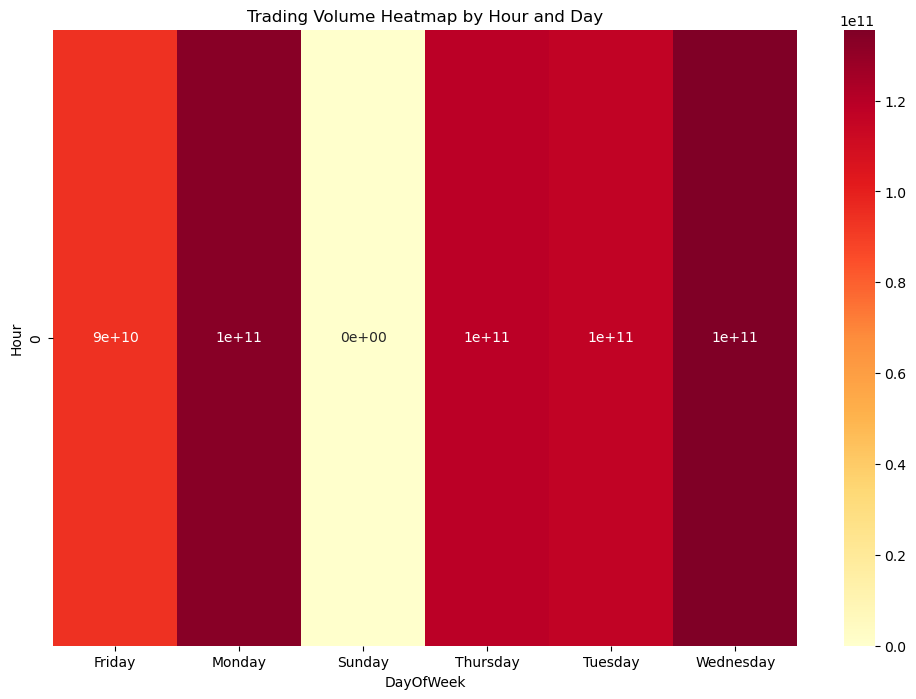

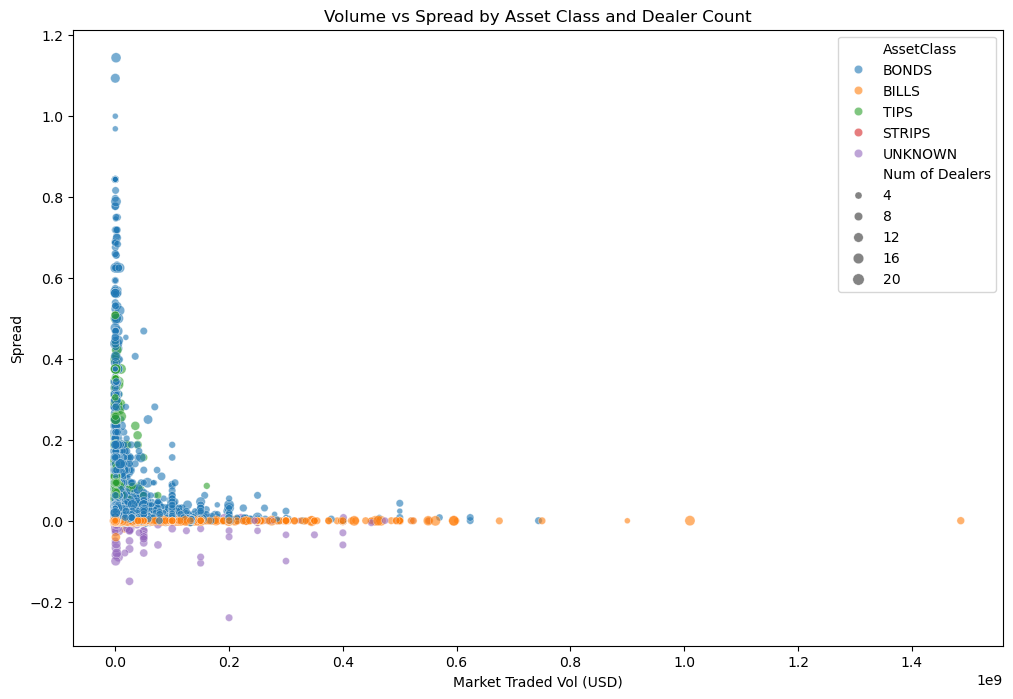

In [63]:
# Time-based Analysis
df['Date'] = pd.to_datetime(df['let me tak'])
df['Hour'] = df['Date'].dt.hour
df['DayOfWeek'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()

# Heatmap of trading activity
pivot_table = df.pivot_table(
    values='Market Traded Vol (USD)',
    index='Hour',
    columns='DayOfWeek',
    aggfunc='sum'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0e')
plt.title('Trading Volume Heatmap by Hour and Day')

# Volume vs Spread Analysis with multiple dimensions
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='Market Traded Vol (USD)',
    y='Spread',
    hue='AssetClass',
    size='Num of Dealers',
    alpha=0.6
)
plt.title('Volume vs Spread by Asset Class and Dealer Count')

Text(0.5, 1.0, 'Client Clusters based on Trading Patterns')

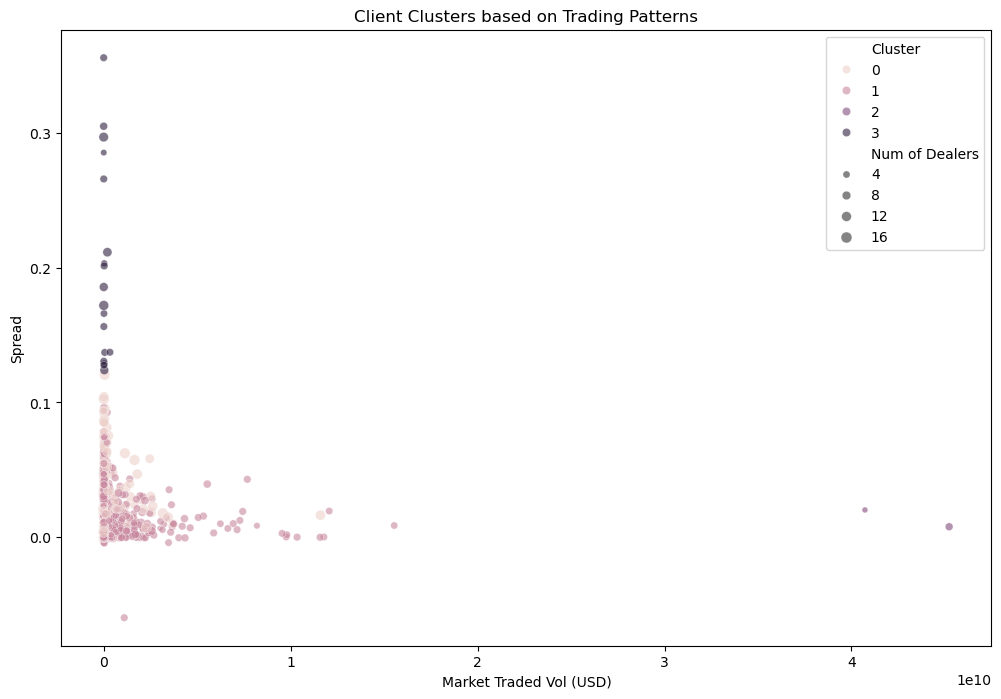

In [64]:
# Client clustering based on trading patterns
client_features = df.groupby('Client').agg({
    'Market Traded Vol (USD)': 'sum',
    'Num of Dealers': 'mean',
    'First Response Time (Sec)': 'mean',
    'Spread': 'mean',
    'Years to Maturity': 'mean'
}).reset_index()

# Normalize features for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(client_features.drop('Client', axis=1))

# Perform clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
client_features['Cluster'] = kmeans.fit_predict(features_scaled)

# Visualize clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=client_features,
    x='Market Traded Vol (USD)',
    y='Spread',
    hue='Cluster',
    size='Num of Dealers',
    alpha=0.6
)
plt.title('Client Clusters based on Trading Patterns')

### slippage related

In [18]:
df.columns

Index(['let me tak', 'Id', 'Client', 'RFQStatus', 'InstrumentSubGroup',
       'Market Traded Vol (USD)', 'Our Traded Vol', 'TiedWonVol',
       'Num of Dealers', 'Trader', 'Sales', 'Covered Vol', 'ActionStr', 'Tier',
       'InstrumentCode', 'InstrumentDescription', 'AssetClass', 'Market',
       'LegNo', 'Maturity Date', 'RFQNumberOfQuotes', 'Buy/Sell',
       'Best Bid Price', 'Mid Price', 'Best Ask Price', 'Deal Value',
       'AwayFromMid', 'TickIdentifier', 'Deal Spread', 'Cover', 'CoverPnL',
       'SettlementDays', 'SettlementDate', 'SettlementStops', 'RFQ CreateTime',
       'RFQ ClosedTime', 'AnAutoReplyRFQs', 'First Response Time (Sec)',
       'TradeSizeBucket', 'Sector', 'MaturityBucket', 'Years to Maturity',
       'Yield', 'Converted Best Bid Price', 'Converted Mid Price',
       'Converted Best Ask Price', 'Converted Deal Value', 'Converted Cover',
       'Spread', 'Slippage'],
      dtype='object')

Text(0, 0.5, 'Count')

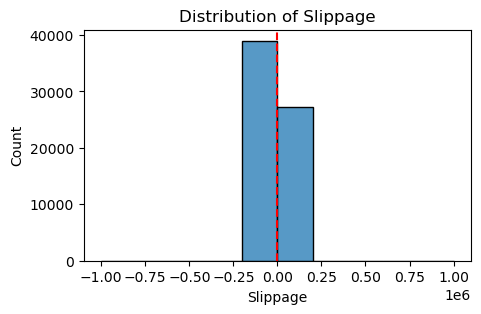

In [19]:
# 1. Basic Slippage Distribution Analysis
plt.figure(figsize=(5,3))
sns.histplot(data=df, x='Slippage', bins=10)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution of Slippage')
plt.xlabel('Slippage')
plt.ylabel('Count')

In [70]:
# 2. Slippage by Trade Size and Time
# Create trade size buckets
df['Volume_Bucket'] = pd.qcut(df['Market Traded Vol (USD)'], 
                            q=5, 
                            labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])

# Time analysis
df['Hour'] = pd.to_datetime(df['RFQ CreateTime']).dt.hour
df['DayOfWeek'] = pd.to_datetime(df['RFQ CreateTime']).dt.day_name()

In [89]:
df.head(3)

,let me tak,Id,Client,RFQStatus,InstrumentSubGroup,Market Traded Vol (USD),Our Traded Vol,TiedWonVol,Num of Dealers,Trader,...,Converted Best Ask Price,Converted Deal Value,Converted Cover,Spread,Slippage,Date,Hour,DayOfWeek,Month,Volume_Bucket
0,2024-09-30,66FA7D45432800D20002,Client1,Done,OFFTHERUN,100000000,100000000,100000000,6,Trader1,...,99.562500,99.558594,99.558594,0.023438,-0.007812,2024-09-30,6,Monday,September,Very Large
1,2024-09-30,TRSY_20240930_15961,Client2,Done,"OFFTHERUN,DOUBLEOLDS",2100000,2100000,2100000,5,Trader2,...,101.735826,101.726562,101.726562,0.023438,-0.002456,2024-09-30,16,Monday,September,Medium
2,2024-09-30,TRSY_20240930_314,Client2,Done,ONTHERUN,53000000,53000000,53000000,5,Trader3,...,99.769531,99.761719,99.761719,0.007812,0.003906,2024-09-30,15,Monday,September,Very Large


In [20]:
# Calculate outlier boundaries
Q1 = df['Slippage'].quantile(0.25)
Q3 = df['Slippage'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[
    (df['Slippage'] < lower_bound) | 
    (df['Slippage'] > upper_bound)
]

# Print summary
print(f"Number of outliers: {len(outliers)}")
print(f"Total number of trades: {len(df)}")
print(f"Percentage of outliers: {(len(outliers)/len(df)*100):.2f}%")

# Print outlier values
print("\nOutlier Slippage values:")
print(outliers['Slippage'].sort_values())

Number of outliers: 6299
Total number of trades: 66172
Percentage of outliers: 9.52%

Outlier Slippage values:
53031   -999999.00
23010   -999999.00
23011   -999999.00
23012   -999999.00
53014   -999999.00
           ...    
53092      9999.99
23004      9999.99
2448     999999.00
48179    999999.00
50807    999999.00
Name: Slippage, Length: 6299, dtype: float64


<Figure size 2000x1200 with 0 Axes>

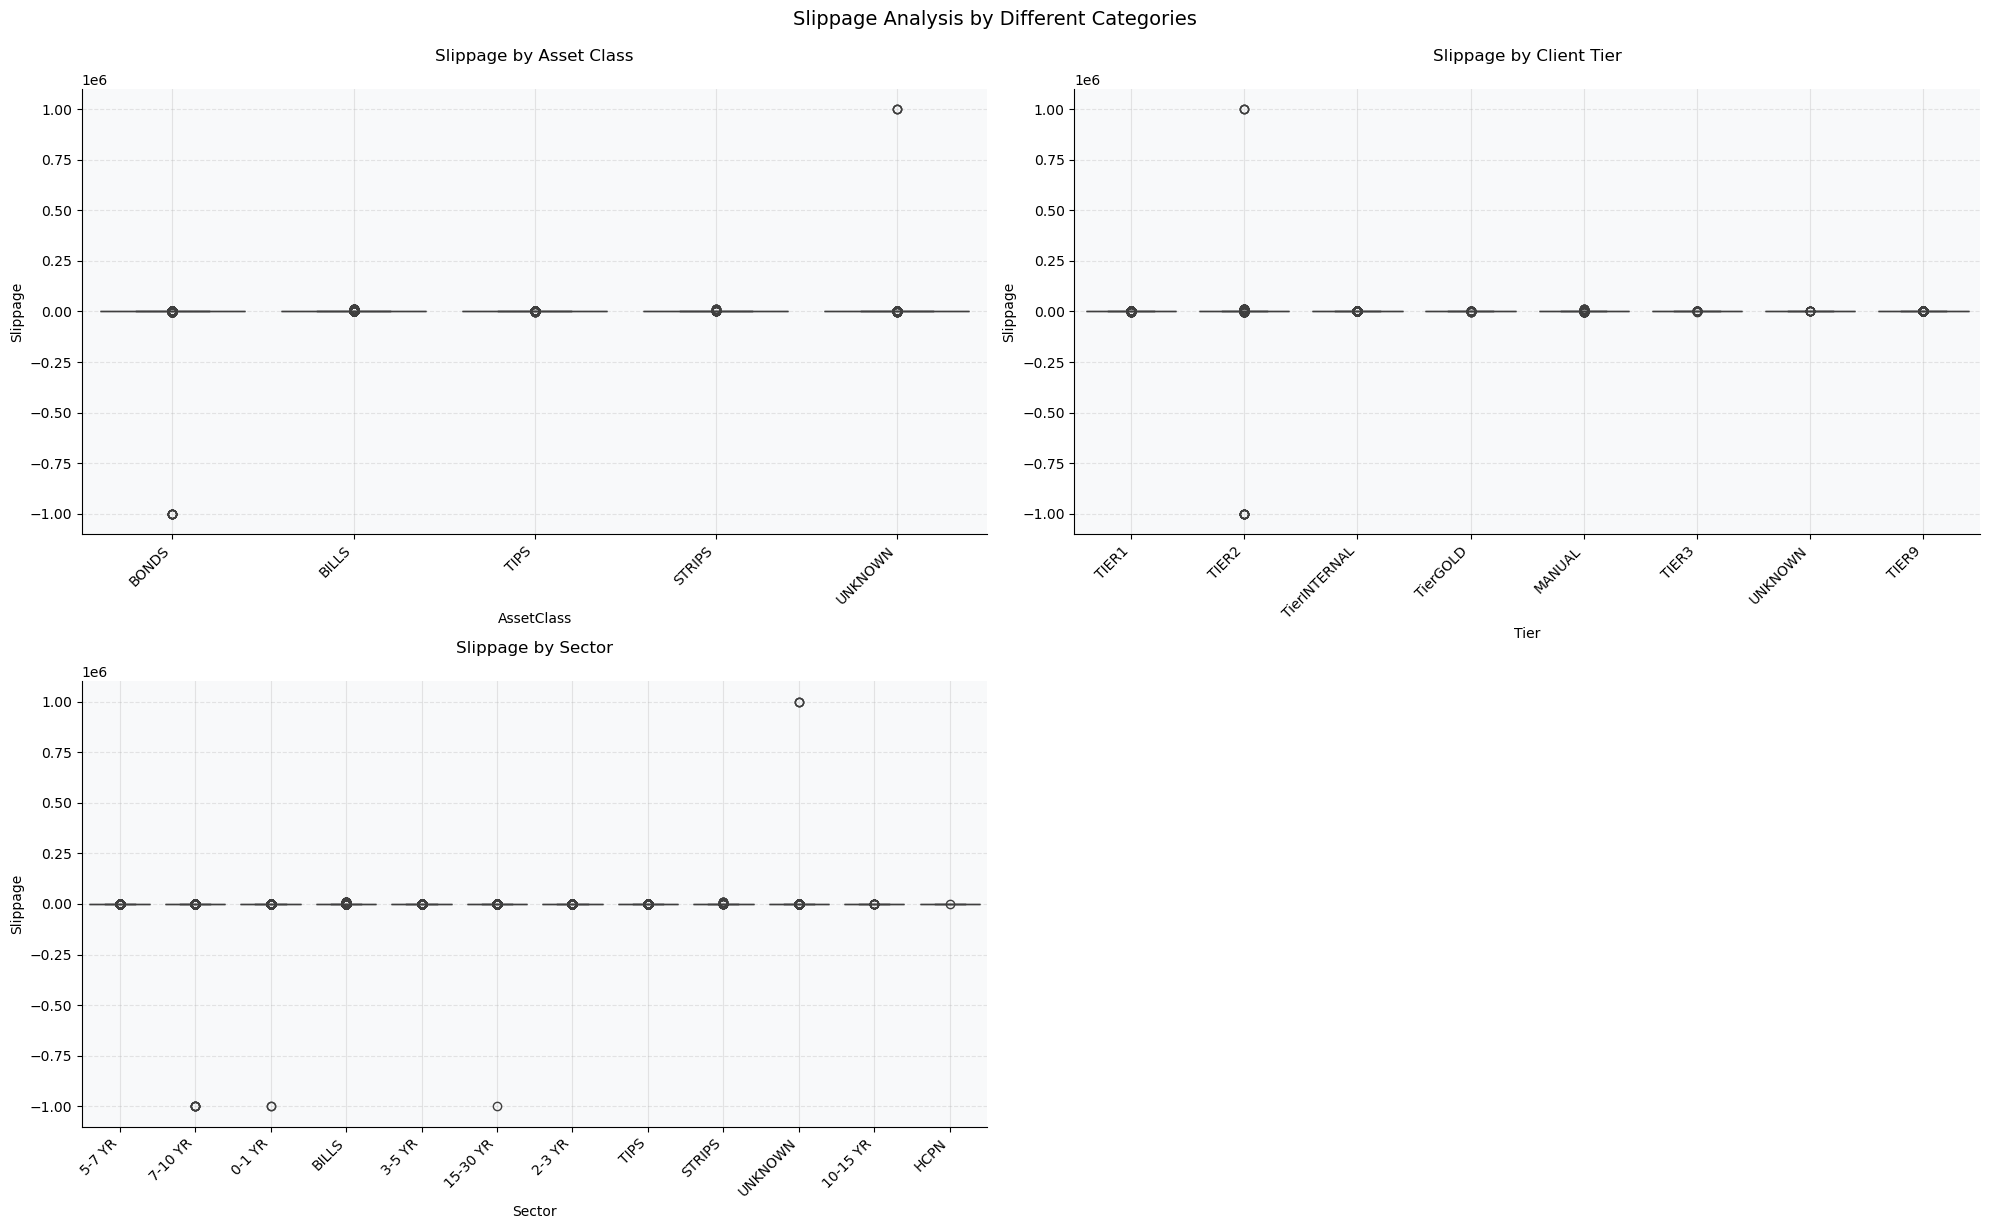

In [21]:
# Create a figure with better dimensions and spacing
plt.figure(figsize=(20, 12))

# Create subplots with better spacing
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 1. Slippage by Asset Class
sns.boxplot(data=df, x='AssetClass', y='Slippage', ax=ax1)
ax1.set_title('Slippage by Asset Class', fontsize=12, pad=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_ylabel('Slippage')
ax1.grid(True, alpha=0.3)

# 2. Slippage by Client Tier
sns.boxplot(data=df, x='Tier', y='Slippage', ax=ax2)
ax2.set_title('Slippage by Client Tier', fontsize=12, pad=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_ylabel('Slippage')
ax2.grid(True, alpha=0.3)

# 3. Slippage by Sector
sns.boxplot(data=df, x='Sector', y='Slippage', ax=ax3)
ax3.set_title('Slippage by Sector', fontsize=12, pad=20)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.set_ylabel('Slippage')
ax3.grid(True, alpha=0.3)

# Add some styling improvements
for ax in [ax1, ax2, ax3]:
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add light grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    
    # Set background color
    ax.set_facecolor('#f8f9fa')
    
    # Adjust y-axis limits to show outliers better
    y_min = df['Slippage'].min()
    y_max = df['Slippage'].max()
    ax.set_ylim(y_min - abs(y_min)*0.1, y_max + abs(y_max)*0.1)

# Remove the empty fourth subplot
ax4.remove()

plt.tight_layout()

# Optional: Add a title for the entire figure
fig.suptitle('Slippage Analysis by Different Categories', fontsize=14, y=1.02)

# Save the figure with high DPI
plt.savefig('slippage_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

The box plots clearly show that while most trades across asset classes, client tiers, and sectors have minimal slippage (clustering around zero), there are occasional significant deviations that warrant attention. Of particular interest is how my tier's execution quality compares to others - if I consistently see larger boxes or more outliers in my tier, it might suggest I'm trading during less optimal times or in more volatile instruments. The sector breakdown is especially valuable as it helps me identify which areas of my trading might need more careful timing or size consideration to minimize negative price impact. If I notice my preferred sectors showing wider spread boxes or more frequent outliers, I might want to discuss with my sales coverage about optimal execution strategies or consider breaking larger trades into smaller pieces. Additionally, this visualization helps me understand if I'm getting fair and consistent execution relative to the market, which is crucial for my transaction cost analysis and best execution requirements. The relatively symmetric distribution around zero across most categories is reassuring, but the outliers suggest there might be specific trading conditions or scenarios where I should be more cautious or perhaps employ different trading strategies.

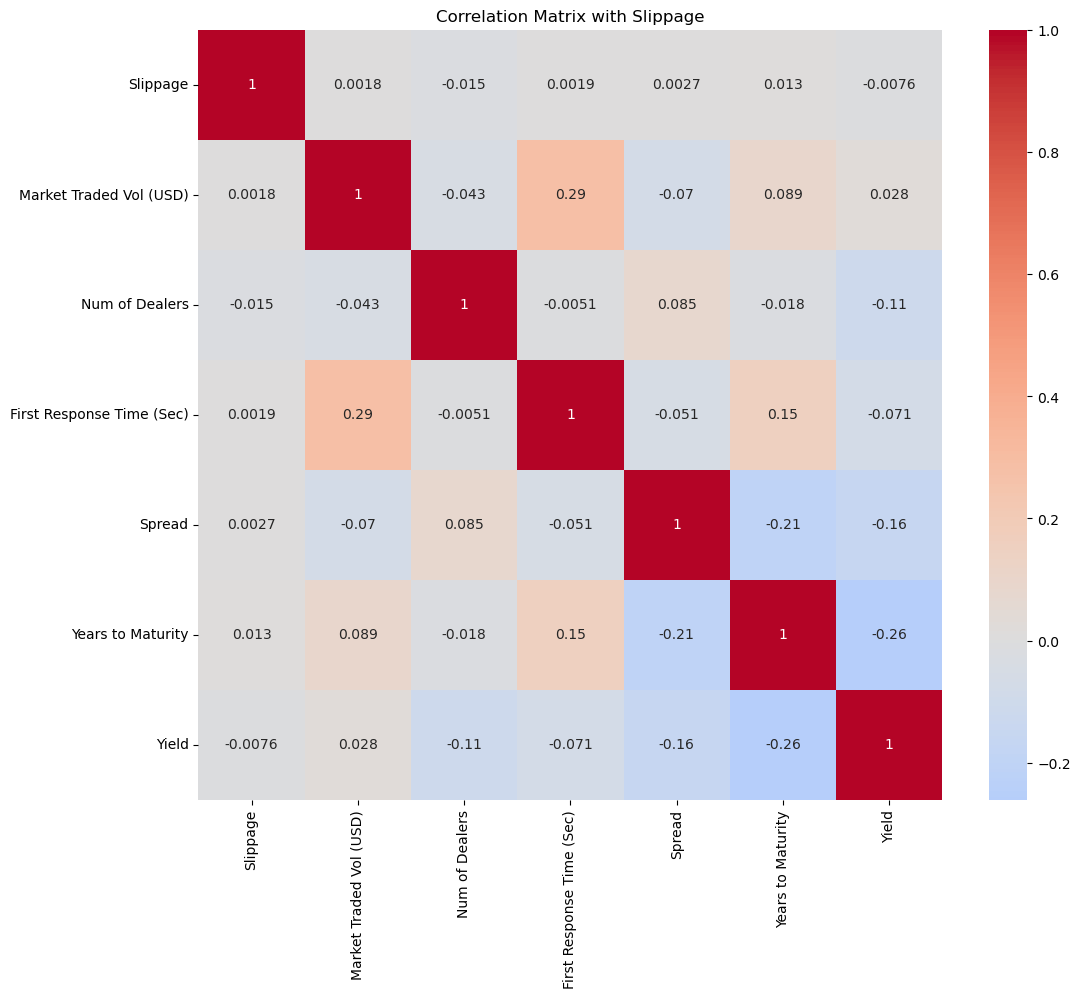

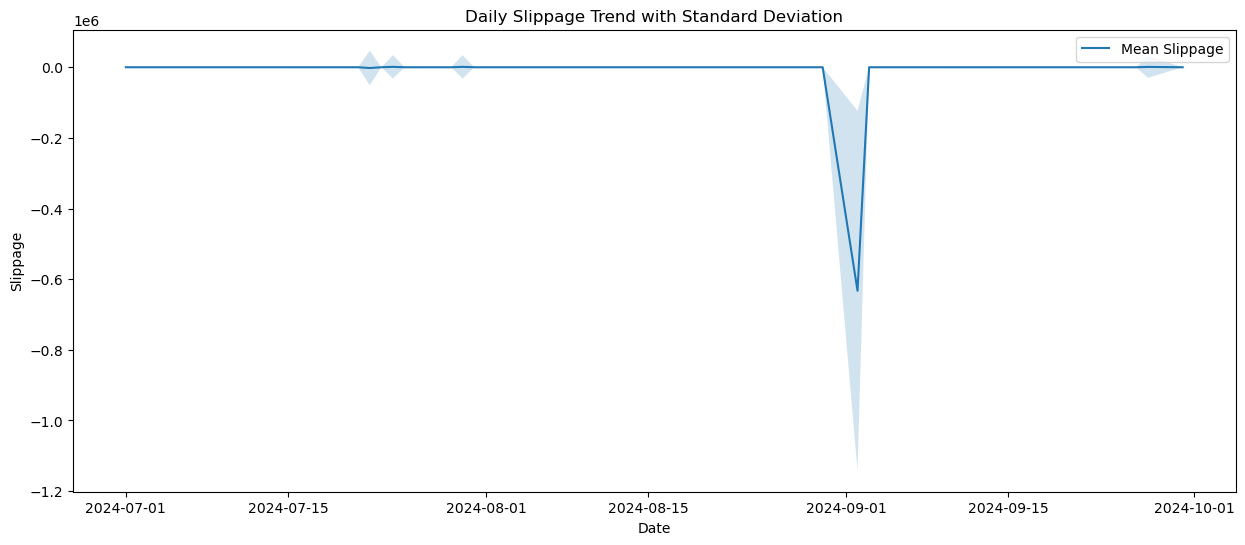

In [22]:
# 7. Statistical Analysis
# Correlation analysis
correlation_metrics = [
    'Slippage',
    'Market Traded Vol (USD)',
    'Num of Dealers',
    'First Response Time (Sec)',
    'Spread',
    'Years to Maturity',
    'Yield'
]

plt.figure(figsize=(12, 10))
sns.heatmap(df[correlation_metrics].corr(),
            annot=True,
            cmap='coolwarm',
            center=0)
plt.title('Correlation Matrix with Slippage')

# 8. Time Series Analysis of Slippage
df['Date'] = pd.to_datetime(df['RFQ CreateTime']).dt.date
daily_slippage = df.groupby('Date')['Slippage'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(15, 6))
plt.plot(daily_slippage['Date'], daily_slippage['mean'], label='Mean Slippage')
plt.fill_between(daily_slippage['Date'],
                 daily_slippage['mean'] - daily_slippage['std'],
                 daily_slippage['mean'] + daily_slippage['std'],
                 alpha=0.2)
plt.title('Daily Slippage Trend with Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Slippage')
plt.legend()